<a href="https://colab.research.google.com/github/ahouzio/PGM_project/blob/main/score_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Function to add noise - this is a basic implementation
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy


100%|██████████| 9912422/9912422 [00:00<00:00, 148953354.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109625062.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33723717.65it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19340638.34it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class ScoreEstimationModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(ScoreEstimationModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Adaptive pooling layer to flatten the output regardless of input image size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # 64 channels, 4x4 spatial dimensions
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # Applying layers in forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        # Adaptive pooling and flattening
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
input_channels = 1  # For grayscale images like MNIST
output_size = 28 * 28  # Flattened size of the output image (e.g., for MNIST)

model = ScoreEstimationModel(input_channels, output_size)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print_interval = 100  # Print every 100 batches
num_epochs = 10
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        noisy_inputs = add_noise(inputs)
        inputs_flat = inputs.view(inputs.size(0), -1)  # Flatten the target images

        optimizer.zero_grad()

        # Forward pass
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs_flat)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_interval == 0:  # Print every 'print_interval' batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/print_interval:.4f}")
            running_loss = 0.0



Epoch [1/10], Step [100/938], Loss: 0.1256
Epoch [1/10], Step [200/938], Loss: 0.1211
Epoch [1/10], Step [300/938], Loss: 0.1181
Epoch [1/10], Step [400/938], Loss: 0.1133
Epoch [1/10], Step [500/938], Loss: 0.1116
Epoch [1/10], Step [600/938], Loss: 0.1089
Epoch [1/10], Step [700/938], Loss: 0.1062
Epoch [1/10], Step [800/938], Loss: 0.1044
Epoch [1/10], Step [900/938], Loss: 0.1035
Epoch [2/10], Step [100/938], Loss: 0.1010
Epoch [2/10], Step [200/938], Loss: 0.1000
Epoch [2/10], Step [300/938], Loss: 0.0985
Epoch [2/10], Step [400/938], Loss: 0.0974
Epoch [2/10], Step [500/938], Loss: 0.0964
Epoch [2/10], Step [600/938], Loss: 0.0950
Epoch [2/10], Step [700/938], Loss: 0.0945
Epoch [2/10], Step [800/938], Loss: 0.0950
Epoch [2/10], Step [900/938], Loss: 0.0938
Epoch [3/10], Step [100/938], Loss: 0.0940
Epoch [3/10], Step [200/938], Loss: 0.0932
Epoch [3/10], Step [300/938], Loss: 0.0924
Epoch [3/10], Step [400/938], Loss: 0.0918
Epoch [3/10], Step [500/938], Loss: 0.0923
Epoch [3/10

In [ ]:
# Assuming you've already imported necessary modules and defined 'transform'
# If not, you can import them as follows:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# Load the test dataset
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the DataLoader for the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
dataiter = iter(testloader)
images, _ = next(dataiter)
noisy_images = add_noise(images)

# Denoise the images using the model
model.eval()
with torch.no_grad():
    denoised_images = model(noisy_images)
    denoised_images = denoised_images.view_as(images)  # Reshape back to original dimensions

# Convert to numpy for display
original_images = images.numpy()
noisy_images = noisy_images.numpy()
denoised_images = denoised_images.numpy()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_images(original, noisy, denoised, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original Images
        plt.subplot(3, num_images, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Noisy Images
        plt.subplot(3, num_images, num_images+i+1)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised Images
        plt.subplot(3, num_images, 2*num_images+i+1)
        plt.imshow(denoised[i].squeeze(), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.show()

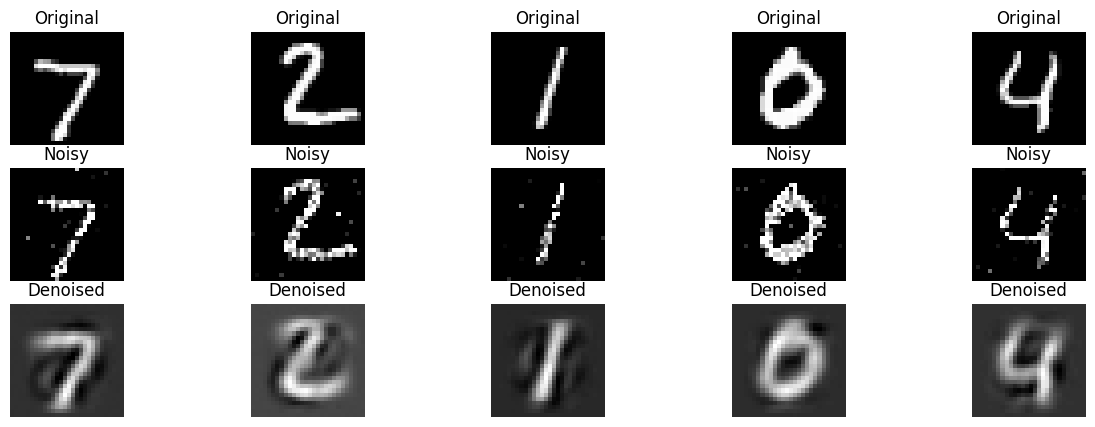

In [ ]:
# Plot the images using your defined 'plot_images' function
plot_images(original_images, noisy_images, denoised_images)

In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
from google.colab import files
files.download('model_state_dict.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
input_shape = (28, 28, 1)


In [ ]:
def create_score_model(input_shape):


    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(np.prod(input_shape))  # Output layer to match input dimensions
    ])

    return model

In [ ]:
score_model = create_score_model(input_shape)

In [ ]:
print(score_model)

In [ ]:
def denoise_image(noisy_image, score_model, num_steps=100, step_size=0.01):


    denoised_image = np.copy(noisy_image)

    for step in range(num_steps):
        # Estimate the score (gradient of log probability) at the current image
        score = score_model.estimate_score(denoised_image)

        # Update the image by following the score
        denoised_image += step_size * score

        # Optionally, you can include a noise term depending on the annealing schedule

    return denoised_image

In [ ]:
score_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
train_images_reshaped = train_images.reshape((-1, 784))  # Reshape to [num_samples, 784]
test_images_reshaped = test_images.reshape((-1, 784))  # Reshape to [num_samples, 784]

In [ ]:
score_model.fit(train_images_noisy, train_images_reshaped, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10


ValueError: ignored